Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset Loaded Successfully!

=== TYPE ASSIGNMENT SUMMARY ===
Numeric (continuous): 5
Categorical (unordered): 7
Categorical (ordered): 275
TOTAL columns: 287

Target dtype: float64
Target missing values: 0
Sample of target values: [ 1.  0.  3.  2.  4.  6.  5.  7. 10.  8.]


,Q274: Number of Children
Count,2012.000000
Missing Values,0.000000
Mean,1.346421
Median,1.000000
Mode,0.000000
Standard Deviation,1.346773
Variance,1.813796
Min,0.000000
Max,10.000000
Range,10.000000


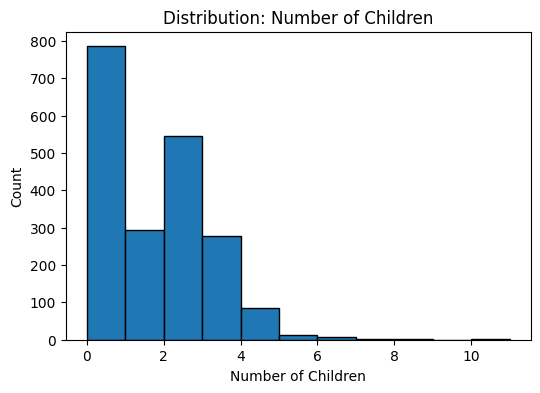


=== Frequency Table: Number of Children ===


,Frequency,count,Proportion (%)
0,0.0,785,0.000000
1,1.0,294,2.173913
2,2.0,545,4.347826
3,3.0,278,6.521739
4,4.0,84,8.695652
5,5.0,13,10.869565
6,6.0,8,13.043478
7,7.0,2,15.217391
8,8.0,1,17.391304
9,10.0,2,21.739130


In [1]:
# =========================
# 1️⃣ Mount Google Drive and Load Data
# =========================
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Mount your Google Drive
drive.mount('/content/drive')

# Load the preprocessed CSV
file_path = '/content/drive/MyDrive/Colab Notebooks/preprocessed_data.csv'
df = pd.read_csv(file_path)

print("✅ Dataset Loaded Successfully!\n")

# =========================
# 2️⃣ Define target and feature groups
# =========================
target = "Q274: How many children do you have"

# Continuous numeric features
always_numeric = [
    "O1_LONGITUDE: Geographical Coordinates - Longitude",
    "O2_LATITUDE: Geographical Coordinates - Latitude",
    "Q261: Year of birth",
    "Q262: Age",
    "Q270: Number of people in household",
]

# Unordered categorical (nominal)
unordered_cats = [
    "N_REGION_ISO: Region ISO 3166-2",
    "Q266: Country of birth: Respondent",
    "Q267: Country of birth: Mother of the respondent",
    "Q268: Country of birth: Father of the respondent",
    "Q272: Language at home",
    "Q289: Religious denominations - major groups",
    "Q290: Ethnic group",
]

# Derive ordered categorical (ordinal) features
all_q = [c for c in df.columns if c.startswith("Q")]
manual_lists = set(always_numeric) | set(unordered_cats)
ordered_cats = [c for c in all_q if c not in manual_lists]

# =========================
# 3️⃣ Assign dtypes by group
# =========================

# Continuous numeric → float
for col in always_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Unordered categorical → category (no order)
for col in unordered_cats:
    if col in df.columns:
        df[col] = df[col].astype("category")

# Ordered categorical → ordered category (preserve Likert order)
for col in ordered_cats:
    if col in df.columns:
        vals = pd.Series(df[col]).dropna().unique()
        try:
            # Try numeric sorting first (e.g. 1–5 scale)
            codes = sorted(vals, key=lambda x: float(x))
        except Exception:
            # Fall back to lexicographic order if strings
            codes = sorted(vals)
        df[col] = pd.Categorical(df[col], categories=codes, ordered=True)

# =========================
# 4️⃣ Clean and validate target
# =========================
if target in df.columns:
    df[target] = pd.to_numeric(df[target], errors="coerce")
else:
    raise KeyError(f"❌ Target column '{target}' not found in dataset!")

# Drop rows with missing or invalid target
df = df.dropna(subset=[target])
df = df[df[target] >= 0]

# =========================
# 5️⃣ Summary diagnostics
# =========================
print("=== TYPE ASSIGNMENT SUMMARY ===")
print(f"Numeric (continuous): {len([c for c in always_numeric if c in df])}")
print(f"Categorical (unordered): {len([c for c in unordered_cats if c in df])}")
print(f"Categorical (ordered): {len(ordered_cats)}")
print(f"TOTAL columns: {df.shape[1]}")
print()
print("Target dtype:", df[target].dtype)
print("Target missing values:", df[target].isna().sum())
print("Sample of target values:", df[target].unique()[:10])

# =========================
# 5️⃣ Key Metrics of Target Variable
# =========================

target_series = df[target].dropna()

# Basic descriptive statistics
metrics = {
    "Count": len(target_series),
    "Missing Values": df[target].isna().sum(),
    "Mean": target_series.mean(),
    "Median": target_series.median(),
    "Mode": target_series.mode().iloc[0] if not target_series.mode().empty else np.nan,
    "Standard Deviation": target_series.std(),
    "Variance": target_series.var(),
    "Min": target_series.min(),
    "Max": target_series.max(),
    "Range": target_series.max() - target_series.min(),
    "Skewness": target_series.skew(),
    "Kurtosis": target_series.kurtosis(),
}

metrics_df = pd.DataFrame(metrics, index=["Q274: Number of Children"]).T
display(metrics_df)

# =========================
# 6️⃣ Distribution Visualization
# =========================
plt.figure(figsize=(6, 4))
target_series.hist(bins=range(0, int(target_series.max()) + 2), edgecolor='black')
plt.title('Distribution: Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.grid(False)
plt.show()

# =========================
# 7️⃣ Frequency Table
# =========================
freq_table = (
    target_series.value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "Number of Children", "Q274: How many children do you have": "Frequency"})
)
freq_table["Proportion (%)"] = 100 * freq_table["Frequency"] / freq_table["Frequency"].sum()

print("\n=== Frequency Table: Number of Children ===")
display(freq_table)



In [8]:
# =========================
# 2️⃣ LLM-Guided Feature Engineering with Ordered-to-Numeric Conversion (Safe Version)
# =========================
!pip install --upgrade openai --quiet

import openai, os, re, ast
import pandas as pd
import numpy as np
from getpass import getpass

# -------------------------
# 0️⃣ Securely input OpenAI API key
# -------------------------
api_key = getpass("Enter your OpenAI API key: ").strip()
os.environ['OPENAI_API_KEY'] = api_key
openai.api_key = api_key
print("✅ OpenAI API key set securely.")

# -------------------------
# 1️⃣ Convert ordered categorical columns to numeric in-place (store mapping)
# -------------------------
category_mappings = {}  # Store original categories for restoration

for col in ordered_cats:
    if col in df.columns and isinstance(df[col].dtype, pd.CategoricalDtype):
        category_mappings[col] = df[col].cat.categories
        df[col] = df[col].cat.codes + 1  # Numeric codes (1-based)

# -------------------------
# 2️⃣ Prepare feature list for LLM (exclude target!)
# -------------------------
feature_list = [col for col in df.columns if col != target]

prompt = f"""
You are a fertility doctor and family planning demographer.
I have a dataset with the following features: {feature_list}
The target variable is "{target}".

Please generate exactly 10 new engineered features using Python pandas code on a dataframe named 'df' that have strong relationship with the target variable.

You may use:
- Aggregations (mean, sum, etc.)
- Interactions between numeric columns
- Non-linear transforms (log, square, etc.)
- Indexes or composite scores

Requirements:
- Do NOT use the target variable '{target}' in any new feature.
- Always use **double quotes** for all column names to avoid syntax errors.
- Use the exact dataframe column names from df. For example, 'Q262: Age'.
- Handle missing values safely.
- Output only valid Python pandas code
- For each engineered feature, explain how the feature relates to "{target}" by commenting with # in the code.
- Do not use import function.
"""

# -------------------------
# 3️⃣ Safety whitelist
# -------------------------
SAFE_ATTRS = {
    "pd": {"DataFrame", "Series", "concat", "crosstab", "to_datetime"},
    "np": {"array", "mean", "median", "std", "log1p", "log", "max", "min", "nan"},
    "df": {"set_index","reset_index","assign","rename","sort_values","loc","iloc","groupby",
           "agg","mean","sum","rolling","plot","apply","__getitem__","max","min"}
}

def is_code_safe(src: str) -> bool:
    tree = ast.parse(src)
    for node in ast.walk(tree):
        if isinstance(node, (ast.Import, ast.ImportFrom, ast.With, ast.AsyncWith, ast.Try)):
            return False
        if isinstance(node, ast.Call):
            if isinstance(node.func, ast.Name) and node.func.id in {'eval','exec','open','__import__'}:
                return False
        if isinstance(node, ast.Attribute):
            base = getattr(node.value, 'id', None)
            if base in SAFE_ATTRS and node.attr not in SAFE_ATTRS[base]:
                return False
    return True

# -------------------------
# 4️⃣ Call OpenAI API
# -------------------------
response = openai.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are an expert Python data engineer."},
        {"role": "user", "content": prompt}
    ],
    temperature=0
)

# -------------------------
# 5️⃣ Extract Python code
# -------------------------
generated_code = response.choices[0].message.content
code_match = re.search(r"```python(.*?)```", generated_code, re.DOTALL)
python_code = code_match.group(1).strip() if code_match else generated_code.strip()
print("✅ Generated feature engineering code received (not executed).")
print(python_code)

# -------------------------
# 6️⃣ Check safety
# -------------------------
if not is_code_safe(python_code):
    raise ValueError("❌ Generated code failed safety checks! Execution aborted.")

# -------------------------
# 7️⃣ Execute safely and ensure new features are added
# -------------------------
existing_columns = set(df.columns.tolist())
exec(python_code, {'df': df, 'np': np, 'pd': pd})

# -------------------------
# 7️⃣1 Ensure all LLM-generated features exist (fill missing with 0 if necessary)
# -------------------------
new_features = [col for col in df.columns if col not in existing_columns]
for f in new_features:
    if f not in df.columns:
        df[f] = 0  # fallback if feature somehow missing

print(f"\n✅ New features added: {new_features}\n")

# -------------------------
# 8️⃣ Restore original categorical columns
# -------------------------
for col, cats in category_mappings.items():
    df[col] = pd.Categorical.from_codes(df[col]-1, categories=cats, ordered=True)

# -------------------------
# 9️⃣ Preview first 5 rows
# -------------------------
display(df.head())

# -------------------------
# 🔹 Post-check: classify new features
# -------------------------
numeric_new = df[new_features].select_dtypes(include=np.number).columns.tolist()
ordered_new = [f for f in new_features if f not in numeric_new and isinstance(df[f].dtype, pd.CategoricalDtype) and df[f].cat.ordered]
unordered_new = [f for f in new_features if f not in numeric_new and isinstance(df[f].dtype, pd.CategoricalDtype) and not df[f].cat.ordered]

print("✅ New features classified by type:")
print("Numeric:", numeric_new)
print("Ordered categorical:", ordered_new)
print("Unordered categorical:", unordered_new)

Enter your OpenAI API key: ··········
✅ OpenAI API key set securely.
✅ Generated feature engineering code received (not executed).
# 1. Family Importance Score: Sum of importance placed on family and child qualities
df["Family_Importance_Score"] = df[["Q1: Important in life: Family", "Q7: Important child qualities: good manners", "Q8: Important child qualities: independence"]].sum(axis=1)  # Higher family importance may correlate with having more children.

# 2. Work-Life Balance Score: Difference between importance of work and family
df["Work_Life_Balance_Score"] = df["Q5: Important in life: Work"] - df["Q1: Important in life: Family"]  # A negative score may indicate a preference for family over work, potentially leading to more children.

# 3. Child Qualities Score: Average of important child qualities
df["Child_Qualities_Avg"] = df[["Q7: Important child qualities: good manners", "Q8: Important child qualities: independence", "Q9: Important child qualities: hard work", "Q10: Importa

<string>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<string>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<string>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<string>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

,N_REGION_ISO: Region ISO 3166-2,O1_LONGITUDE: Geographical Coordinates - Longitude,O2_LATITUDE: Geographical Coordinates - Latitude,Q1: Important in life: Family,Q2: Important in life: Friends,Q3: Important in life: Leisure time,Q4: Important in life: Politics,Q5: Important in life: Work,Q6: Important in life: Religion,Q7: Important child qualities: good manners,...,Immigration_Perception_Score,Political_Engagement_Score,Social_Activism_Score,Education_Score,Social_Class_Score,Family_Importance_Score,Work_Life_Balance_Score,Child_Qualities_Avg,Trust_Avg,Age_Squared
0,702001.0,103.82,1.23,1.0,2.0,1.0,3.0,2.0,2.0,2.0,...,10,11,3.0,7.5,3.5,4,1,1.545455,1.666667,1369
1,702001.0,103.81,1.23,1.0,2.0,1.0,3.0,3.0,2.0,1.0,...,4,9,2.5,7.0,2.5,4,2,1.545455,1.666667,1764
2,702001.0,103.84,1.22,1.0,1.0,2.0,2.0,2.0,3.0,1.0,...,10,10,3.0,7.0,4.0,4,1,1.545455,2.666667,784
3,702001.0,103.84,1.22,1.0,2.0,2.0,3.0,3.0,4.0,1.0,...,10,9,2.5,7.0,4.5,3,2,1.545455,1.666667,900
4,702001.0,103.84,1.23,1.0,1.0,1.0,4.0,1.0,2.0,1.0,...,4,13,3.0,5.0,5.0,3,0,1.545455,2.666667,1024


✅ New features classified by type:
Numeric: ['Family_Importance_Score', 'Work_Life_Balance_Score', 'Child_Qualities_Avg', 'Trust_Avg', 'Age_Squared']
Ordered categorical: []
Unordered categorical: []


1.7.6
Categorical columns to encode: ['N_REGION_ISO: Region ISO 3166-2', 'Q1: Important in life: Family', 'Q2: Important in life: Friends', 'Q3: Important in life: Leisure time', 'Q4: Important in life: Politics', 'Q5: Important in life: Work', 'Q6: Important in life: Religion', 'Q7: Important child qualities: good manners', 'Q8: Important child qualities: independence', 'Q9: Important child qualities: hard work', 'Q10: Important child qualities: feeling of responsibility', 'Q11: Important child qualities: imagination', 'Q12: Important child qualities: tolerance and respect for other people', 'Q13: Important child qualities: thrift saving money and things', 'Q14: Important child qualities: determination perseverance', 'Q15: Important child qualities: religious faith', 'Q16: Important child qualities: unselfishness', 'Q17: Important child qualities: obedience', 'Q18: Neighbors: Drug addicts', 'Q19: Neighbors: People of a different race', 'Q20: Neighbors: People who have AIDS', 'Q21: Nei

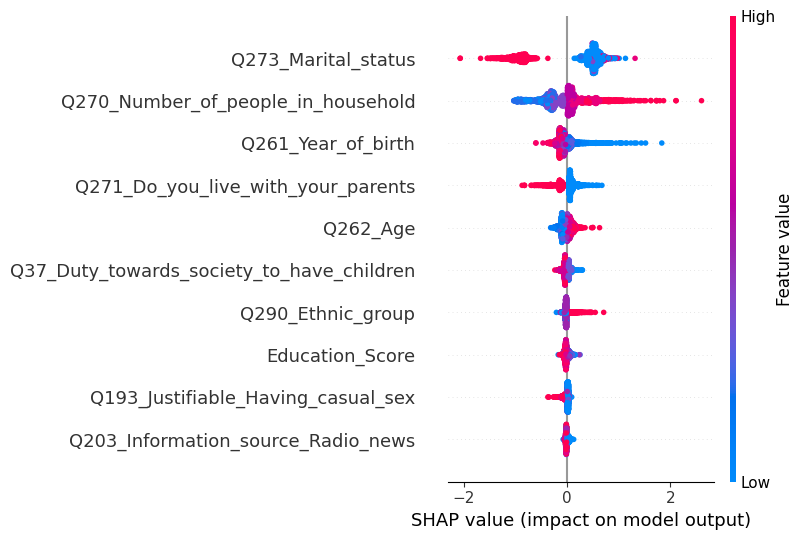

Top 10 Features by SHAP importance:


,feature,importance
269,Q273_Marital_status,0.652135
266,Q270_Number_of_people_in_household,0.326360
257,Q261_Year_of_birth,0.132311
267,Q271_Do_you_live_with_your_parents,0.132112
258,Q262_Age,0.074884
39,Q37_Duty_towards_society_to_have_children,0.052579
285,Q290_Ethnic_group,0.040593
294,Education_Score,0.032848
193,Q193_Justifiable_Having_casual_sex,0.031948
203,Q203_Information_source_Radio_news,0.020740



Selected top 50 features for Neural Network / other models:
['Q273_Marital_status', 'Q270_Number_of_people_in_household', 'Q261_Year_of_birth', 'Q271_Do_you_live_with_your_parents', 'Q262_Age', 'Q37_Duty_towards_society_to_have_children', 'Q290_Ethnic_group', 'Education_Score', 'Q193_Justifiable_Having_casual_sex', 'Q203_Information_source_Radio_news', 'Q202_Information_source_TV_news', 'Q94_Active_Inactive_membership_Church_or_religious_organization', 'Q276_Highest_educational_level_Respondent_s_Spouse_ISCED_2011_', 'Q106_Incomes_should_be_made_more_equal_vs_There_should_be_greater_incentives_for_individual_effort', 'Q282_Respondent_s_Spouse_Occupational_group', 'Q186_Justifiable_Sex_before_marriage', 'Q242_Democracy_Religious_authorities_interpret_the_laws', 'Q107_Private_vs_state_ownership_of_business', 'Q173_Religious_person', 'Q153_Aims_of_country_second_choice', 'Q275_Highest_educational_level_Respondent_ISCED_2011_', 'Q3_Important_in_life_Leisure_time', 'Q33_Jobs_scarce_Men_sho

In [21]:
# =========================
# 🔹 Full Pipeline: Categorical Encoding → XGBoost → SHAP → Feature Selection
# =========================

!pip install shap --quiet

!pip install xgboost==1.7.6

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.preprocessing import LabelEncoder

print(xgb.__version__)

# -------------------------
# 0️⃣ Define features & target
# -------------------------
target = "Q274: How many children do you have"
X_fe = df.drop(columns=[target])
y_fe = df[target]

# -------------------------
# 1️⃣ Encode categorical features to numeric
# -------------------------
categorical_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns to encode:", categorical_cols)

for col in categorical_cols:
    le = LabelEncoder()
    X_fe[col] = le.fit_transform(X_fe[col].astype(str))

# Ensure all columns are numeric
X_fe = X_fe.apply(pd.to_numeric, errors='coerce').fillna(0)

# -------------------------
# 2️⃣ Sanitize column names for XGBoost
# -------------------------
X_fe.columns = X_fe.columns.str.replace(r"[^0-9a-zA-Z_]+", "_", regex=True)

# -------------------------
# 3️⃣ Train XGBoost regressor
# -------------------------
model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
model.fit(X_fe, y_fe)

# -------------------------
# 4️⃣ SHAP explanation
# -------------------------
explainer = shap.TreeExplainer(model)   # stable for XGBoost trees
shap_values = explainer.shap_values(X_fe)

# -------------------------
# 5️⃣ Summary plot of SHAP values
# -------------------------
shap.summary_plot(shap_values, X_fe, max_display=10)

# -------------------------
# 6️⃣ Compute mean absolute SHAP importance
# -------------------------
shap_importance = pd.DataFrame({
    'feature': X_fe.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print("Top 10 Features by SHAP importance:")
display(shap_importance.head(10))

# -------------------------
# 7️⃣ Select top features for downstream models (e.g., Neural Network)
# -------------------------
top_n = 50  # choose top N features
top_features = shap_importance['feature'][:top_n].tolist()
X_selected = X_fe[top_features]

missing_features = [f for f in top_features if f not in X_fe.columns]
if missing_features:
    print("⚠️ Warning: Some top features are missing from the dataframe:")
    print(missing_features)

print(f"\nSelected top {top_n} features for Neural Network / other models:")
print(top_features)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
44/44 - 7s - 165ms/step - loss: 0.6738 - mae: 0.7838 - val_loss: 0.6010 - val_mae: 0.8249
Epoch 2/100
44/44 - 1s - 15ms/step - loss: 0.4839 - mae: 0.6188 - val_loss: 0.5461 - val_mae: 0.7162
Epoch 3/100
44/44 - 1s - 19ms/step - loss: 0.4361 - mae: 0.5621 - val_loss: 0.5112 - val_mae: 0.7272
Epoch 4/100
44/44 - 1s - 14ms/step - loss: 0.4164 - mae: 0.5382 - val_loss: 0.4590 - val_mae: 0.6304
Epoch 5/100
44/44 - 1s - 26ms/step - loss: 0.4150 - mae: 0.5404 - val_loss: 0.4405 - val_mae: 0.6172
Epoch 6/100
44/44 - 0s - 11ms/step - loss: 0.3712 - mae: 0.5001 - val_loss: 0.4816 - val_mae: 0.5721
Epoch 7/100
44/44 - 1s - 16ms/step - loss: 0.3834 - mae: 0.4834 - val_loss: 0.4622 - val_mae: 0.5699
Epoch 8/100
44/44 - 0s - 10ms/step - loss: 0.3691 - mae: 0.4757 - val_loss: 0.4479 - val_mae: 0.5615
Epoch 9/100
44/44 - 0s - 10ms/step - loss: 0.3517 - mae: 0.4504 - val_loss: 0.4731 - val_mae: 0.5601
Epoch 10/100
44/44 - 0s - 5ms/step - loss: 0.3242 - mae: 0.4280 - val_loss: 0.4795 - val_m

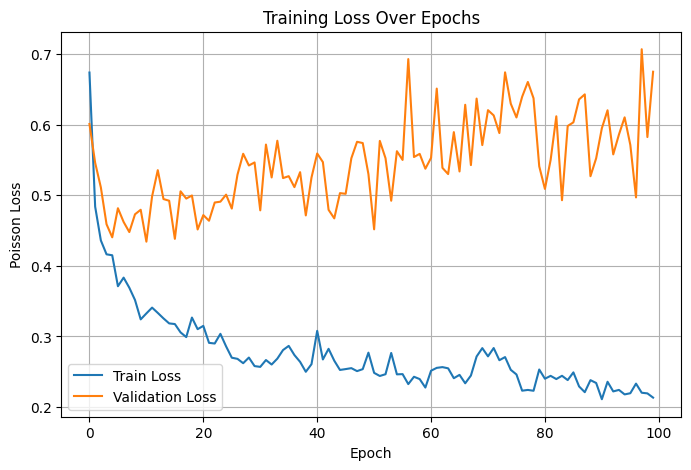


Sample predictions vs. actuals:
y_true=1.000 | y_pred=1.212
y_true=0.000 | y_pred=0.000
y_true=0.000 | y_pred=0.000
y_true=0.000 | y_pred=0.906
y_true=4.000 | y_pred=4.565


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout
from tensorflow.keras.losses import Poisson
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 0️⃣ Prepare X and y from SHAP-selected features
# -------------------------
# Ensure your data is float32
X = X_selected.values.astype(np.float32)  # X_selected from SHAP step
y = y_fe.values.astype(np.float32)        # target variable

# (Optional but important!) Scale features for stable training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 70/30 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# -------------------------
# 1️⃣ Build Poisson Regression Neural Network
# -------------------------
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='exponential')  # ensures positive predictions
])

# Try a slightly higher learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss=Poisson(), metrics=['mae'])

# -------------------------
# 2️⃣ Train model
# -------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=2
)

# -------------------------
# 3️⃣ Predict and evaluate
# -------------------------
y_pred = model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n✅ Poisson Neural Network Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

# -------------------------
# 4️⃣ Visualize training loss
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# 5️⃣ Quick diagnostic check
# -------------------------
print("\nSample predictions vs. actuals:")
for i in range(5):
    print(f"y_true={y_test[i]:.3f} | y_pred={y_pred[i]:.3f}")


Epoch 1/100
44/44 - 8s - 171ms/step - loss: 1.5602 - val_loss: 1.4417
Epoch 2/100
44/44 - 1s - 19ms/step - loss: 1.2643 - val_loss: 1.3248
Epoch 3/100
44/44 - 0s - 11ms/step - loss: 1.1932 - val_loss: 1.2325
Epoch 4/100
44/44 - 0s - 6ms/step - loss: 1.1462 - val_loss: 1.1800
Epoch 5/100
44/44 - 0s - 5ms/step - loss: 1.1051 - val_loss: 1.1788
Epoch 6/100
44/44 - 0s - 5ms/step - loss: 1.0729 - val_loss: 1.1370
Epoch 7/100
44/44 - 0s - 5ms/step - loss: 1.0538 - val_loss: 1.1429
Epoch 8/100
44/44 - 0s - 6ms/step - loss: 1.0544 - val_loss: 1.1297
Epoch 9/100
44/44 - 0s - 5ms/step - loss: 1.0283 - val_loss: 1.1198
Epoch 10/100
44/44 - 0s - 6ms/step - loss: 1.0294 - val_loss: 1.1231
Epoch 11/100
44/44 - 0s - 5ms/step - loss: 1.0264 - val_loss: 1.1070
Epoch 12/100
44/44 - 0s - 6ms/step - loss: 0.9993 - val_loss: 1.1096
Epoch 13/100
44/44 - 0s - 5ms/step - loss: 0.9885 - val_loss: 1.1150
Epoch 14/100
44/44 - 0s - 5ms/step - loss: 0.9968 - val_loss: 1.1145
Epoch 15/100
44/44 - 0s - 5ms/step - lo

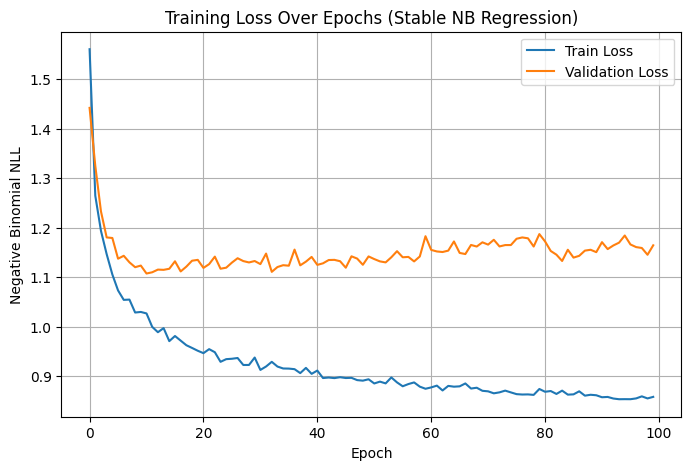

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 0️⃣ Prepare X and y
# -------------------------
X = X_selected.values.astype(np.float32)
y = y_fe.values.astype(np.float32)

# Ensure non-negative targets
if np.any(y < 0):
    raise ValueError("Negative Binomial regression requires non-negative targets (counts).")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# -------------------------
# 1️⃣ Stable Negative Binomial Loss
# -------------------------
def stable_negative_binomial_loss(y_true, y_pred_params):
    """
    y_pred_params[..., 0] = log(mu)
    y_pred_params[..., 1] = log(theta)
    """
    eps = 1e-6  # prevent log(0)
    log_mu = tf.clip_by_value(y_pred_params[..., 0], -10.0, 10.0)
    log_theta = tf.clip_by_value(y_pred_params[..., 1], -10.0, 10.0)

    mu = tf.exp(log_mu)
    theta = tf.exp(log_theta)

    y_true = tf.maximum(y_true, 0.0)

    log_likelihood = (
        tf.math.lgamma(y_true + theta)
        - tf.math.lgamma(theta)
        - tf.math.lgamma(y_true + 1.0)
        + theta * (tf.math.log(theta + eps) - tf.math.log(theta + mu + eps))
        + y_true * (tf.math.log(mu + eps) - tf.math.log(theta + mu + eps))
    )

    return -tf.reduce_mean(log_likelihood)

# -------------------------
# 2️⃣ Build Neural Network
# -------------------------
inputs = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(2)(x)  # log(mu) and log(theta)
model = Model(inputs, outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # smaller LR!

model.compile(optimizer=optimizer, loss=stable_negative_binomial_loss)

# -------------------------
# 3️⃣ Train Model
# -------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=2
)

# -------------------------
# 4️⃣ Predict and Evaluate
# -------------------------
y_pred_params = model.predict(X_test)
mu_pred = np.exp(np.clip(y_pred_params[:, 0], -10, 10))  # prevent inf

# Clean any NaNs (safety)
mu_pred = np.nan_to_num(mu_pred, nan=0.0, posinf=np.max(y), neginf=0.0)

rmse = np.sqrt(mean_squared_error(y_test, mu_pred))
mae = mean_absolute_error(y_test, mu_pred)
r2 = r2_score(y_test, mu_pred)

print("\n✅ Negative Binomial Neural Network Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")

# -------------------------
# 5️⃣ Plot Training Loss
# -------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Binomial NLL')
plt.title('Training Loss Over Epochs (Stable NB Regression)')
plt.legend()
plt.grid(True)
plt.show()
